# Health Study – Part 1  

This notebook analyzes data from a health study containing information about participants’ age, sex, height, weight, blood pressure, cholesterol level, smoking habits, and disease occurrence.  
The purpose is to perform basic descriptive analysis, simulation, confidence interval estimation, and hypothesis testing in accordance with the assignment instructions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

REQUIRED = ["age", "weight", "height", "systolic_bp", "cholesterol"]

df = pd.read_csv("data/health_study_dataset.csv")

missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")
else:
    print("All required columns are present.")

df.head()

All required columns are present.


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


In [2]:
print("DataFrame info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

df["sex"] = (
    df["sex"]
    .astype(str).str.strip().str.upper()
    .replace({"FEMALE": "F", "MALE": "M"})
    .astype("category")
)

df["smoker"] = (
    df["smoker"]
    .astype(str).str.strip().str.title()
    .replace({"Y": "Yes", "N": "No"})
    .astype("category")
)

df["sex"] = df["sex"].cat.set_categories(["F", "M"])
df["smoker"] = df["smoker"].cat.set_categories(["No", "Yes"])

df["disease"] = df["disease"].astype(int)

cat_summary = pd.DataFrame({
    "sex": df["sex"].value_counts(),
    "smoker": df["smoker"].value_counts(),
    "disease": df["disease"].value_counts()
})
cat_summary

df.head()

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB
None

Missing values per column:
id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64


,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


### Missing values check
Missingness was inspected using `df.info()` and `df.isna().sum()`.  
No missing values were found in the required columns, therefore, no imputation or row dropping was performed.  
If any missing values appear later, they will be handled only for the variables used in that specific analysis (for example `df["systolic_bp"].dropna()`), and the target column (`disease`) will not be changed or filled in.

In [3]:
numeric_cols = ["age", "weight", "height", "systolic_bp", "cholesterol"]

desc_stats = df[numeric_cols].agg(["mean", "median", "std", "min", "max"]).T.round(2).sort_values("mean", ascending=False)

print("Descriptive statistics for numerical variables:")
desc_stats

Descriptive statistics for numerical variables:


,mean,median,std,min,max
height,171.85,171.35,9.80,144.4,200.40
systolic_bp,149.18,149.40,12.79,106.8,185.90
weight,73.41,73.20,13.69,33.7,114.40
age,49.43,50.00,14.50,18.0,90.00
cholesterol,4.93,4.97,0.85,2.5,7.88


### Descriptive statistics
The table above shows the main descriptive statistics for the numerical variables.  
The mean, median and standard deviation describe central tendency and variation, giving a clear overview of the participants’ health characteristics.

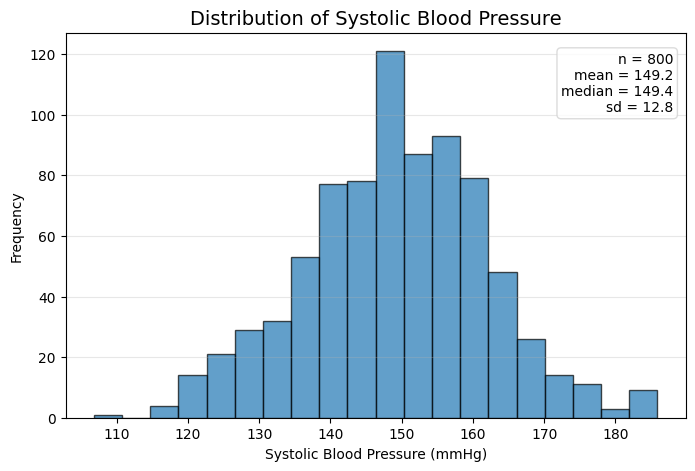

In [ ]:
x = df["systolic_bp"].dropna()
n = len(x); mean = x.mean(); median = x.median(); sd = x.std(ddof=1)

plt.figure(figsize=(8, 5))
plt.hist(x, bins=20, edgecolor="black", alpha=0.7)
plt.title("Distribution of Systolic Blood Pressure", fontsize=14)
plt.xlabel("Systolic Blood Pressure (mmHg)")
plt.ylabel("Frequency")

plt.grid(axis="y", alpha=0.3)

text = f"n = {n}\nmean = {mean:.1f}\nmedian = {median:.1f}\nsd = {sd:.1f}"
plt.gca().text(
    0.98, 0.95, text,
    transform=plt.gca().transAxes,
    ha="right", va="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, edgecolor="lightgray")
)

plt.show()

### Distribution of systolic blood pressure
The histogram above shows how systolic blood pressure is distributed among participants.  
Most values appear to cluster around the central range, with fewer individuals at the very high and very low ends.  
This gives an initial sense of the population’s blood pressure profile before performing statistical tests.